<a href="https://colab.research.google.com/github/Yogesh7920/Pascal-VOC/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
"""
Needed for BERT.
"""
!pip install tensorflow-text
!pip install tensorflow_addons

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from keras.utils import plot_model
import tensorflow_datasets as tfds
from tensorflow.image import resize, ResizeMethod 
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, \
                                    BatchNormalization, GlobalAveragePooling2D, Lambda, \
                                    Embedding, GlobalAveragePooling1D, Concatenate, LSTM, \
                                    Bidirectional, Input, Reshape
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import Resizing, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import   VGG19, vgg19, VGG16, vgg16, InceptionV3, inception_v3, \
                                            Xception, xception
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.callbacks import ReduceLROnPlateau

# sklearn
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

## Downloading data from drive

In [3]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

get_resized_images = True

data_path = '/content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/cache/'
model_path = '/content/drive/MyDrive/IIT Palakkad/Sem-6/Deep Learning/Project/Models/'

if get_resized_images:
    abstract_images = np.load(data_path + 'abstract_images_resized.npy', allow_pickle=True)
else:
    abstract_images = np.load(data_path + 'abstract_images.npy', allow_pickle=True)
abstract_images = abstract_images[:, :, :, :3]

if get_resized_images:
    pascal_images = np.load(data_path + 'pascal_images_resized.npy', allow_pickle=True)
else:
    pascal_images = np.load(data_path + 'pascal_images.npy', allow_pickle=True)

abstract_targets = np.load(data_path + 'abstract_targets.npy', allow_pickle=True)
pascal_targets = np.load(data_path + 'pascal_targets.npy', allow_pickle=True)

abstract_annots_concat = np.load(data_path + 'abstract_annots_concat.npy', allow_pickle=True)
pascal_annots_concat = np.load(data_path + 'pascal_annots_concat.npy', allow_pickle=True)

### Reshape input data if required

In [4]:
"""Input shape for the CNN"""
input_shape=(224, 224, 3)

def resize_images(dataset):
    ls = []
    for img in tqdm(dataset):
        img = resize(img, size=input_shape[0:2], method=ResizeMethod.AREA)
        ls.append(img)
    return np.array(ls)

if not get_resized_images:
    pascal_images = resize_images(pascal_images)
    abstract_images = resize_images(abstract_images)
    np.save(data_path + 'abstract_images_resized.npy', abstract_images_resized)
    np.save(data_path + 'pascal_images_resized.npy', pascal_images_resized)

## Functions necessary for model building

In [5]:
def get_text_model(vocab_size=2000, embedding_dim=128):
    """
    A basic model for learning text embeddings.
    """
    input = Input(shape=(), name="text_model_input", dtype='string')
    vectorize_layer = TextVectorization(
                        max_tokens=vocab_size,
                        output_mode='int',
                        output_sequence_length=250)(input)
    x = Embedding(vocab_size, embedding_dim)(vectorize_layer)
    x = Bidirectional(LSTM(embedding_dim))(x)
    model = Model(input, x)
    return model

def get_bert_model(trainable=False):
    """
    BERT to learn the embeddings
    """
    text_input = Input(shape=(), dtype=tf.string, name='text_model_input')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    return tf.keras.Model(text_input, net)

def get_cnn_model(pre_trained, input_preprocessor=None, shape=(224, 224, 3), allow_train_from=None):
    pre_trained.layers[0]._name = "cnn_model_input"
    if allow_train_from is not None:
        """Fine tune the pretrained model if needed."""
        layer_names = [layer.name for layer in pre_trained.layers]
        idx = layer_names.index(allow_train_from)
        for (i, layer) in enumerate(pre_trained.layers[:idx]):
            pre_trained.layers[i].trainable = False
    else:
        pre_trained.trainable = False
    return Model(inputs=pre_trained.input, outputs=pre_trained.output)

def tokenize(texts, num_words=2000, maxlen=150):
    """Tokenizer"""
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    abstract = pad_sequences(sequences, maxlen=maxlen)
    return abstract

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

## Preprocessing and Data Preparation

In [6]:
input_preprocessor = inception_v3.preprocess_input
abstract_preprocessed = input_preprocessor(np.copy(abstract_images))
pascal_preprocessed = input_preprocessor(np.copy(pascal_images))
dataset = {
    'abstract': {
        'annots_concat': abstract_annots_concat,
        'orig_images': abstract_images,
        'images': abstract_preprocessed,
        'targets': abstract_targets
    },
    'pascal': {
        'annots_concat': pascal_annots_concat,
        'orig_images': pascal_images,
        'images': pascal_preprocessed,
        'targets': pascal_targets
    },
    'concat': {
        'annots_concat': np.append(abstract_annots_concat, pascal_annots_concat),
        'orig_images': np.append(abstract_images, pascal_images, axis=0),
        'images': np.append(abstract_preprocessed, pascal_preprocessed, axis=0),
        'targets': np.append(abstract_targets, pascal_targets, axis=0) 
    }
}

del abstract_annots_concat
del pascal_annots_concat
del abstract_images
del pascal_images
del abstract_preprocessed
del pascal_preprocessed
del abstract_targets
del pascal_targets

### Convert the dataset as tensorflow datasets

In [7]:
CUR_SET = 'concat'
BATCH_SIZE = 32
MAX_EPOCHS = 500
full_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "text_model_input": dataset[CUR_SET]["annots_concat"], 
        "cnn_model_input": dataset[CUR_SET]["images"]
    }, 
    dataset[CUR_SET]["targets"]
))
misc_dataset = tf.data.Dataset.from_tensor_slices((dataset[CUR_SET]["orig_images"], )) 

### Train test split of the dataset

In [8]:
DATASET_SIZE = len(dataset[CUR_SET]['images'])
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
TEST_SIZE = int(0.2 * DATASET_SIZE)


train_dataset = full_dataset.take(TRAIN_SIZE).batch(BATCH_SIZE)
misc_train_dataset = misc_dataset.take(TRAIN_SIZE)
test_dataset = full_dataset.skip(TRAIN_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)
misc_test_dataset = misc_dataset.skip(TRAIN_SIZE).take(TEST_SIZE)
del dataset

### Dataset distribution

In [9]:
class_weights = train_dataset.reduce(0, lambda x, y: x + tf.reduce_sum(y[1], axis=0)).numpy()
df = pd.DataFrame(class_weights, columns=["Count"])
df.index = labels
df

,Count
person,911
bird,83
cat,109
cow,41
dog,182
horse,44
sheep,40
aeroplane,99
bicycle,42
boat,35


### Exploring the dataset

['person']


"b' Mike throws the toy at Jenny who is wearing her new sunglasses. Mike and Jenny throw a Frisbee. Mike and Jenny are having fun at the park. Mike and Jenny are playing frisbee. Jenny and Mike play with a Frisbee. Jenny and Mike are happily playing frisbee. Mike is tossing a frisbee to Jenny Mike is catching a frisbee Jenny has thrown to him outside. Mike and Jenny are playing frisbee in the park. Mike is ready to throw the frisbee to Jenny. Jenny and Mike are playing frisbee outdoors at the playground. Jenny and Mike are having fun throwing the frisbee back and forth with each other. Mike is kicking the Frisbee to Jenny. Mike is throwing a frisbee to Jenny. Mike is trying to kick a frisbee thrown by Jenny. Mike and Jenny are playing Frisbee in a park. Jenny and Mike enjoy a day in the sun. Mike gets ready to throw Jenny a frisbee while Jenny waits with anticipation. Mike and Jenny happily play with the Frisbee. Mike is throwing a frizbee to Jenny in a park. Mike is catching the Frisb

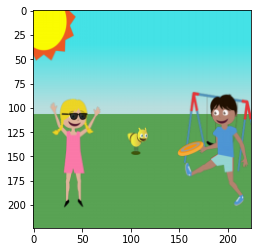

In [10]:
index = np.random.randint(0, TRAIN_SIZE)
for x, y in zip(misc_train_dataset.skip(index).take(1), train_dataset.unbatch().skip(index).take(1)):
    image = np.clip(x[0]/255., 0, 1)
    idxs = y[1]
    annots = y[0]['text_model_input']
plt.imshow(image)
print(labels[idxs.numpy() == 1])
str(annots.numpy())

## Load pretrained models

### BERT from Tensorflow Hub

In [ ]:
if 'preprocessing_layer' in globals():
        del preprocessing_layer
if 'encoder' in globals():
        del encoder

def load_bert_model(trainable):
    """Load the BERT model from tensorflow hub."""
    tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
    global preprocessing_layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    global encoder
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=trainable, name='BERT_encoder')

load_bert_model(trainable=True)

### Inception V3

In [11]:
pre_trained = InceptionV3(include_top = False, input_shape=input_shape, weights = 'imagenet', pooling='avg')

## Build and train the final model

In [17]:
text_model = get_text_model()

allow_train_from='mixed9'
cnn_model = get_cnn_model(pre_trained, input_preprocessor=None, shape=input_shape, allow_train_from=allow_train_from)

x = Concatenate()([text_model.output, cnn_model.output])

x = Dense(512, activation="relu", kernel_regularizer=L2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu", kernel_regularizer=L2(0.001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
output = Dense(20, activation="sigmoid")(x)
model = Model(inputs=[text_model.input, cnn_model.input], outputs=output)

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_model_input (InputLayer)    [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         cnn_model_input[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [18]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=macro_soft_f1, metrics=[macro_f1])

In [15]:
plot_model(pre_trained, to_file='{}task2_cnn.png'.format(model_path), show_shapes=True)
plot_model(model, to_file='{}task2.png'.format(model_path), show_shapes=True)

In [73]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=True)
cp = keras.callbacks.ModelCheckpoint('{}model2'.format(model_path), save_best_only=True, save_format='tf')
history = model.fit(train_dataset, validation_data=test_dataset, epochs=MAX_EPOCHS, callbacks=[es, GarbageCollectorCallback()])

Epoch 1/500
38/38 [==============================] - 6s 170ms/step - loss: 0.4740 - macro_f1: 0.5892 - val_loss: 0.4921 - val_macro_f1: 0.5429
Epoch 2/500
38/38 [==============================] - 6s 170ms/step - loss: 0.4722 - macro_f1: 0.5909 - val_loss: 0.5122 - val_macro_f1: 0.5363
Epoch 3/500
38/38 [==============================] - 6s 170ms/step - loss: 0.4744 - macro_f1: 0.5882 - val_loss: 0.5086 - val_macro_f1: 0.5364
Epoch 4/500
38/38 [==============================] - 6s 171ms/step - loss: 0.4776 - macro_f1: 0.5863 - val_loss: 0.4919 - val_macro_f1: 0.5562
Epoch 5/500
38/38 [==============================] - 6s 171ms/step - loss: 0.4747 - macro_f1: 0.5895 - val_loss: 0.5197 - val_macro_f1: 0.5298
Epoch 6/500
38/38 [==============================] - 6s 171ms/step - loss: 0.4764 - macro_f1: 0.5862 - val_loss: 0.5058 - val_macro_f1: 0.5486
Epoch 7/500
38/38 [==============================] - 6s 170ms/step - loss: 0.4717 - macro_f1: 0.5915 - val_loss: 0.4969 - val_macro_f1: 0.5654

In [ ]:
model.save('{}model2'.format(model_path), save_format='tf')

## Testing the model

### Predicting on the test dataset

In [75]:
y_true = test_dataset.unbatch().map(lambda x, y: y)
arr = []
for x in y_true.take(TEST_SIZE):
    arr.append(x.numpy())

y_true = np.array(arr)
y_pred = model.predict(test_dataset)
y_classes = np.where(y_pred > 0.5, 1, 0)

### Evaluating on the train dataset

In [76]:
model.evaluate(train_dataset)

38/38 [==============================] - 5s 94ms/step - loss: 0.4515 - macro_f1: 0.6047


[0.4515002965927124, 0.6046699285507202]

### Evaluating on the test dataset

In [77]:
model.evaluate(test_dataset)

10/10 [==============================] - 2s 94ms/step - loss: 0.4730 - macro_f1: 0.5764


[0.4730212390422821, 0.5763828158378601]

### Evaluating on the complete dataset

In [78]:
model.evaluate(train_dataset.concatenate(test_dataset))

48/48 [==============================] - 7s 96ms/step - loss: 0.4558 - macro_f1: 0.5988


[0.4558044970035553, 0.5987768769264221]

In [79]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

metric = tfa.metrics.HammingLoss(mode="multilabel", threshold=0.5)
metric.update_state(y_pred, y_true)
print("Hamming Loss: {}".format(metric.result().numpy()))
print("Hamming Score: {}".format(hamming_score(y_true, y_classes)))

Hamming Loss: 0.09300000220537186
Hamming Score: 0.5828888888888889


### Show predictions from the test dataset

Actual: ['person' 'sheep']
Predicted: ['person' 'cow']


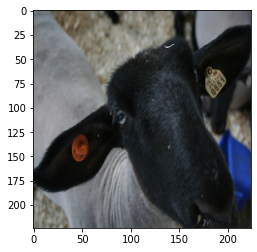

In [80]:
index = np.random.randint(0, TEST_SIZE)
for (image_show, ), (feats, labs) in zip(misc_test_dataset.skip(index).take(1), test_dataset.unbatch().skip(index).take(1)):
    text = feats['text_model_input']
    image = feats['cnn_model_input']

class_ = y_classes[index]
print("Actual: {}".format(labels[labs.numpy() == 1]))
plt.imshow(np.clip(image_show/255., 0, 1))
print("Predicted: {}".format(labels[class_ == 1]))

### Classification Report

In [81]:
print(classification_report(y_true, y_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       185
           1       0.94      0.67      0.78        24
           2       1.00      0.80      0.89        20
           3       0.58      0.78      0.67        18
           4       0.90      0.38      0.53        24
           5       0.92      0.69      0.79        16
           6       0.92      0.65      0.76        17
           7       0.90      0.75      0.82        12
           8       0.81      0.65      0.72        20
           9       0.78      0.78      0.78        23
          10       0.67      0.71      0.69        17
          11       0.53      0.59      0.56        41
          12       0.90      0.87      0.89        31
          13       0.94      0.70      0.80        23
          14       0.33      0.38      0.35         8
          15       0.71      0.44      0.54        39
          16       0.69      0.64      0.66        55
          17       0.50    

## Grad-CAM for the model

In [82]:
"""
Reference: https://keras.io/examples/vision/grad_cam/
The code has been change to suit the requirements of this assignment.
"""


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """First, we create a model that maps the input image to the activations
    of the last conv layer as well as the output predictions."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer_name.output, model.output]
    )
    """Then, we compute the gradient of the top predicted class for our input image
    with respect to the activations of the last conv layer"""
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    """This is the gradient of the output neuron (top predicted or chosen)
    with regard to the output feature map of the last conv layer"""
    grads = tape.gradient(class_channel, last_conv_layer_output)

    """This is a vector where each entry is the mean intensity of the gradient
    over a specific feature map channel"""
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    """We multiply each channel in the feature map array
    by "how important this channel is" with regard to the top predicted class
    then sum all the channels to obtain the heatmap class activation"""
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    """For visualization purpose, we will also normalize the heatmap between 0 & 1"""
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, ax, alpha=0.4):

    """Rescale heatmap to a range 0-255"""
    heatmap = np.uint8(255 * heatmap)

    """Use jet colormap to colorize heatmap"""
    jet = cm.get_cmap("jet")

    """Use RGB values of the colormap"""
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    """Create an image with RGB colorized heatmap"""
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    """Superimpose the heatmap on original image"""
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    ax.imshow(superimposed_img)

### Load the model and compile it (due to custom loss function)

In [ ]:
temp_model = keras.models.load_model('{}model2'.format(model_path), compile=False, custom_objects={'KerasLayer': hub.KerasLayer})

In [84]:
temp_model.compile(optimizer=Adam(learning_rate=1e-3), loss=macro_soft_f1, metrics=[macro_f1])

### Remove the last layer's activation

In [85]:
temp_model.layers[-1].activation = None

### Plot some Grad-CAMs

284
Actual: ['person' 'chair' 'dining table']
Predicted: ['person' 'chair' 'dining table']


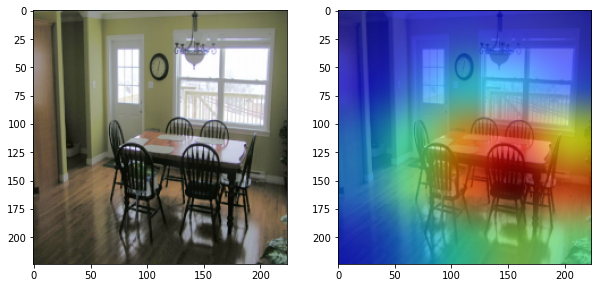

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
index = np.random.randint(0, TEST_SIZE)
for (image_show, ), (feats, labs) in zip(misc_test_dataset.skip(index).take(1), test_dataset.unbatch().skip(index).take(1)):
    text = feats['text_model_input']
    image = feats['cnn_model_input']

class_ = y_classes[index]
print("Actual: {}".format(labels[labs.numpy() == 1]))
print("Predicted: {}".format(labels[class_ == 1]))
image_show = np.clip(image_show/255., 0, 1)
ax[0].imshow(image_show)
last_conv_layer = temp_model.get_layer('mixed10')
input_data = [np.expand_dims(text, axis=0), np.expand_dims(image, axis=0)]
heatmap = make_gradcam_heatmap(input_data, temp_model, last_conv_layer)
display_gradcam(image_show, heatmap, ax[1], alpha=0.006)